## Library and Data Imports

In [1]:
import scipy.stats as stats
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

In [2]:
# read local csv files and put into data frames
data_url = '17zpallnoagi.csv'
zpallnoagi_csv = pd.read_csv(data_url)
raw_tax_df = pd.DataFrame(zpallnoagi_csv)
mhi_data_url = 'MarketHealthIndex_Zip.csv'
market_health_csv = pd.read_csv(mhi_data_url, on_bad_lines='skip', encoding = "ISO-8859-1")
market_health_df = pd.DataFrame(market_health_csv)

## Data Cleaning and Imputation

### Downselection of Features

In [3]:
# Columns used for both data sets
market_health_cols = ['RegionName','MarketHealthIndex','SellForGain','ForeclosureRatio','NegativeEquity','Delinquency',
                      'DaysOnMarket','ZHVI']

zip_tax_cols = ['ZIPCODE','MARS1','MARS2','MARS4','NUMDEP','A00100','N02650', 'A02650','A00200','A00300', 'A00900',
                'A01000','A01700','SCHF','A02300','A02500','N26270','N03220','A03300','N03150','N03210','N03230',
                'A17000','A18425','A18500','A19300','N19570','A19700','A20950','N04800','A04800','A07300','N07180',
                'A07180','N07220','A07220','N09400','A09400','A10600','N11070','A11070','N06500','A06500','A85300']

# filtered and merged together raw data sets 
tax_zip_df = raw_tax_df.filter(zip_tax_cols)
mh_df = market_health_df.filter(market_health_cols, axis=1)
merged_df = pd.merge(tax_zip_df, mh_df, left_on="ZIPCODE", right_on="RegionName")
grouped_df = merged_df.drop(columns=['RegionName'])

# Print the length of the tax_zip_df and mh_df
print("Length of tax_zip_df: ", len(tax_zip_df))
print("Length of mh_df: ", len(mh_df))
print("Length of merged_df: ", len(merged_df))

# most simpliest data frame with zipcode as the key and all other columns as features
display(grouped_df.head())

Length of tax_zip_df:  27760
Length of mh_df:  14089
Length of merged_df:  14003


,ZIPCODE,MARS1,MARS2,MARS4,NUMDEP,A00100,N02650,A02650,A00200,A00300,...,N06500,A06500,A85300,MarketHealthIndex,SellForGain,ForeclosureRatio,NegativeEquity,Delinquency,DaysOnMarket,ZHVI
0,35004,2140.0,2120.0,780.0,3350.0,289966.0,5130.0,292671.0,236776.0,902.0,...,3870.0,27796.0,32.0,4.893179,NaN,NaN,0.092712,0.026738,76.0,147100.0
1,35005,1350.0,870.0,900.0,2230.0,124916.0,3170.0,125810.0,102620.0,261.0,...,2010.0,9187.0,0.0,0.887927,40.00,2.9443,0.250780,0.082988,80.0,75000.0
2,35006,440.0,580.0,170.0,820.0,59411.0,1210.0,59725.0,46012.0,106.0,...,870.0,5089.0,0.0,6.796082,NaN,NaN,0.221277,0.019231,84.0,78500.0
3,35007,4720.0,5180.0,1790.0,8840.0,706211.0,11930.0,714402.0,555765.0,1832.0,...,8520.0,72973.0,90.0,5.600114,84.62,0.6175,0.066375,0.037618,55.0,157700.0
4,35010,3000.0,2710.0,2060.0,5850.0,387333.0,7890.0,391523.0,262452.0,3394.0,...,4740.0,37697.0,688.0,6.150898,NaN,NaN,0.192933,0.017442,147.0,105300.0


### Splitting Training and Holdout Data

Only training data will be used for Exploratory Data Analysis

In [4]:
# splitting data 
# df_eda is 80% of random data, df_holdout is 20% of the remaining data
df_eda, df_holdout = train_test_split(grouped_df, test_size=0.20, random_state=22)
display(df_eda.head())

,ZIPCODE,MARS1,MARS2,MARS4,NUMDEP,A00100,N02650,A02650,A00200,A00300,...,N06500,A06500,A85300,MarketHealthIndex,SellForGain,ForeclosureRatio,NegativeEquity,Delinquency,DaysOnMarket,ZHVI
9140,13850,4710.0,4340.0,710.0,5100.0,806571.0,9940.0,818461.0,517408.0,5937.0,...,7780.0,113416.0,916.0,2.586415,81.82,NaN,0.101289,0.066667,92.0,128500.0
5412,20616,1690.0,920.0,800.0,2500.0,238866.0,3550.0,239927.0,202262.0,329.0,...,2740.0,23869.0,15.0,5.138051,100.00,NaN,0.244229,0.097561,93.5,263200.0
5885,1566,1640.0,1540.0,240.0,1790.0,315416.0,3480.0,318920.0,233627.0,1759.0,...,2880.0,46088.0,189.0,6.323373,100.00,NaN,0.085440,0.081633,76.0,274200.0
4476,46815,6620.0,4850.0,1710.0,7980.0,659101.0,13410.0,666299.0,489028.0,3480.0,...,9400.0,61711.0,161.0,2.110867,NaN,NaN,0.057726,0.047138,49.0,117400.0
12991,23223,13650.0,3550.0,6570.0,14020.0,1010689.0,24430.0,1021980.0,844452.0,1532.0,...,15710.0,99345.0,183.0,2.631840,76.47,6.3815,0.163589,0.034208,63.0,140900.0


### Imputation of Missing Values

In [5]:
# First remove rows missing the target variable of ZHVI
df_eda = df_eda[df_eda['ZHVI'].notna()]

# Split the data into input and target
train_X = df_eda.drop(columns=['ZHVI'])
train_y = df_eda['ZHVI']

# Calculating the missing values
missing_values = train_X.isnull().sum()
missing_values = missing_values[missing_values > 0]

# Creating datafram to display missing data
cols = ['Feature', 'Number Missing', 'Percent Missing']
missing_df = pd.DataFrame(columns=cols)
for col in missing_values.index:
    missing_df.loc[len(missing_df.index)] = {'Feature': col,
                                    'Number Missing': missing_values[col],
                                    'Percent Missing': missing_values[col] / len(df_eda) * 100}

pd.set_option('display.float_format', '{:.1f}'.format)
display(missing_df)

# Remove SellForGain, ForeclosureRatio columns
#train_X = train_X.drop(columns=['SellForGain', 'ForeclosureRatio'])

# Impute missing values using KNN
imputer = KNNImputer(n_neighbors=5)
imputed_values = imputer.fit_transform(train_X)

# Convert the numpy array back into a dataframe
train_X = pd.DataFrame(imputed_values, columns=train_X.columns)

missing_values_after = train_X.isnull().sum()
print('\nTotal missing values after imputation:')
print(len(missing_values_after[missing_values_after > 0]))

,Feature,Number Missing,Percent Missing
0,SellForGain,3645,32.9
1,ForeclosureRatio,8581,77.4
2,NegativeEquity,295,2.7
3,Delinquency,295,2.7
4,DaysOnMarket,107,1.0



Total missing values after imputation:
0


## Exploratory Data Analysis

### Distribution of Key Features and Target Variable

Range of total tax income $5099.00 - $12952497.00
Range of total Zillow's Housing Value Index $32700.00 - $6421400.00


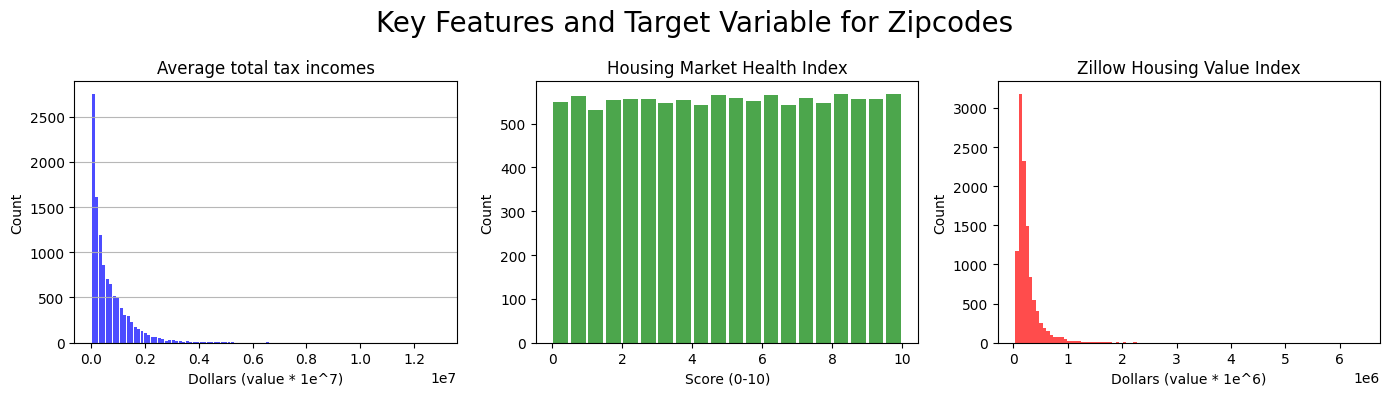

In [6]:
fig, axs = plt.subplots(1,3, figsize=(14,4))

axs[0].ticklabel_format(axis='both')

print(f"Range of total tax income ${min(df_eda['A02650']):.2f} - ${max(df_eda['A02650']):.2f}")
# Create a histogram for 'income'
axs[0].hist(df_eda['A02650'], bins=100, color='blue', alpha=0.7, rwidth=0.85)
axs[0].grid(axis='y', alpha=0.9)
axs[0].set_title('Average total tax incomes')
axs[0].set_xlabel('Dollars (value * 1e^7)')
axs[0].set_ylabel('Count')

# Create a histogram for 'market_health_index'
axs[1].hist(df_eda['MarketHealthIndex'], bins=20, color='green', alpha=0.7, rwidth=0.85)
axs[1].set_title('Housing Market Health Index')
axs[1].set_xlabel('Score (0-10)')
axs[1].set_ylabel('Count')

print(f"Range of total Zillow's Housing Value Index ${min(df_eda['ZHVI']):.2f} - ${max(df_eda['ZHVI']):.2f}")
# Create a histogram for 'zillow_housing_value_index'
axs[2].hist(df_eda['ZHVI'], bins=100, color='red', alpha=0.7)
axs[2].set_title('Zillow Housing Value Index')
axs[2].set_xlabel("Dollars (value * 1e^6)")
axs[2].set_ylabel("Count")

fig.suptitle('Key Features and Target Variable for Zipcodes', fontsize=20)

plt.tight_layout()

### Data Loss from Dataset Merge

In [7]:
available_returns = raw_tax_df.groupby(['STATE']).sum().reset_index()
market_health_zips = market_health_df['RegionName'].tolist()


used_returns = raw_tax_df[raw_tax_df['ZIPCODE'].isin(market_health_zips)]

used_returns = used_returns.groupby(['STATE']).sum().reset_index()


merged_df = pd.merge(available_returns, used_returns, on='STATE', how='inner')

merged_df['Ratio'] = merged_df['N1_y'] / merged_df['N1_x']

print(merged_df.head())

import plotly.express as px

# May need pip install --upgrade nbformat

fig = px.choropleth(merged_df, locations="STATE", color="Ratio", hover_name="STATE", 
                    title='Percentage Use of Zip Codes by State', locationmode='USA-states', scope='usa', color_continuous_scale="Viridis")
fig.show()


  STATE  STATEFIPS_x  ZIPCODE_x  AGI_STUB_x       N1_x    MARS1_x    MARS2_x  \
0    AK          110    5380952           0   690610.0   350390.0   249740.0   
1    AL          576   20736287           0  4068620.0  1683950.0  1498020.0   
2    AR         2455   35462259           0  2428630.0  1002100.0   960340.0   
3    AZ         1180   25160457           0  5955380.0  2738520.0  2180910.0   
4    CA         8868  138152636           0 35656240.0 17534890.0 12530350.0   

    MARS4_x      ELF_x   CPREP_x  ...  A85300_y  N11901_y   A11901_y  \
0   74020.0   598630.0   45860.0  ...   15655.0   47680.0   220760.0   
1  805670.0  3653470.0  212930.0  ...   90746.0  270880.0  1390343.0   
2  417010.0  2198070.0  108510.0  ...  278575.0  155880.0   731445.0   
3  956810.0  5232040.0  408960.0  ...  280924.0  647860.0  3204363.0   
4 5073960.0 31315660.0 2617960.0  ... 3775191.0 4156540.0 26776534.0   

    N11900_y   A11900_y   N11902_y   A11902_y  N12000_y   A12000_y  Ratio  
0   151500

## Model Selection

### Final Data Preparation

Split holdout into validation and train sets and perform same data cleaning as training values.
Normalize all inputs. 

In [8]:
# Remove rows missing the target variable of ZHVI
df_holdout = df_holdout[df_holdout['ZHVI'].notna()]

# Split holdout data into validation and test set
val, test = train_test_split(df_holdout, test_size=0.50, random_state=22)

# Split the data into input and target
val_X = val.drop(columns=['ZHVI'])
val_y = val['ZHVI']

test_X = test.drop(columns=['ZHVI'])
test_y = test['ZHVI']

val_imputed_values = imputer.fit_transform(val_X)
test_imputed_values = imputer.fit_transform(test_X)

# Convert the numpy array back into a dataframe
val_X = pd.DataFrame(val_imputed_values, columns=val_X.columns)
test_X = pd.DataFrame(test_imputed_values, columns=test_X.columns)

# Scale with MinMaxScaler
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(train_X)
train_X_min_max = min_max_scaler.transform(train_X)
val_X_min_max = min_max_scaler.transform(val_X)
test_X_min_max = min_max_scaler.transform(test_X)


# Normalize the train_X data
scaler = StandardScaler()
scaler.fit(train_X)
train_X = scaler.transform(train_X)

# Normalize the val_X and test_X data
val_X = scaler.transform(val_X.to_numpy())
test_X = scaler.transform(test_X.to_numpy())


/Users/kdevoe/Documents/CS/Masters/AAI500/FInal_Project/aai-500-final-group-4/env/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/Users/kdevoe/Documents/CS/Masters/AAI500/FInal_Project/aai-500-final-group-4/env/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names



Function to analzye results of a given regression model for price prediction.

In [9]:
def analyze_results(actual, predictions, name=""):

    print(actual)
    interval_size = 100
    last_interval = 1000
    num_intervals = int(last_interval / interval_size)

    results_df = pd.DataFrame(columns=['Interval', 'Count', 'RMSE', 'Max_Difference'])

    # Process each interval for value
    for i in range(0, num_intervals):

        filtered_actual = []
        filtered_predictions = []
        
        # Filter the actual and predictions to the current interval
        lower_bound = interval_size * i * 1000

        if i == num_intervals - 1:
            upper_bound = np.inf
        else:
            upper_bound = interval_size * (i + 1) * 1000

        for j in range(len(actual)):
            if actual[j] >= lower_bound and actual[j] < upper_bound:
                filtered_actual.append(actual[j])
                filtered_predictions.append(predictions[j])

        # Calculate the metrics for the interval
        rmse = np.sqrt(mean_squared_error(filtered_actual, filtered_predictions))
        max_diff = 0
        for j in range(len(filtered_actual)):
            max_diff = max(abs(filtered_actual[j] - filtered_predictions[j]), max_diff)

        lower = f'${lower_bound / 1000}k'
        if upper_bound == np.inf:
            upper = 'Maximum'
        else:
            upper = f'${upper_bound / 1000}k'
        # Store interval results
        results_df.loc[len(results_df.index)] = {'Interval': f'{lower} to {upper}',
                                                  'Count': len(filtered_actual),
                                                  'RMSE': rmse, 
                                                  'Max_Difference': max_diff}

    # Add the final row for all data
    rmse = np.sqrt(mean_squared_error(actual, predictions))
    max_diff = 0
    for j in range(len(actual)):
        max_diff = max(abs(actual[j] - predictions[j]), max_diff)
    results_df.loc[len(results_df.index)] = {'Interval': 'All Data',
                                                'Count': len(actual),
                                                'RMSE': rmse,
                                                'Max_Difference': max_diff}
        
    # Plot the results
    plt.scatter(actual, predictions, color='blue')
    plt.title(f'{name} Results')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')

    # Add a line for perfect correlation
    min_value = min(min(actual), min(predictions))
    max_value = max(max(actual), max(predictions))
    plt.plot([min_value, max_value], [min_value, max_value], color='red')
    # Add legend
    plt.legend(['Model Results', 'Perfect Correlation'])

    plt.show()

    return results_df

### Linear Regression

Validation results:
[ 89700. 552800. 176300. ... 127300. 306400. 133100.]


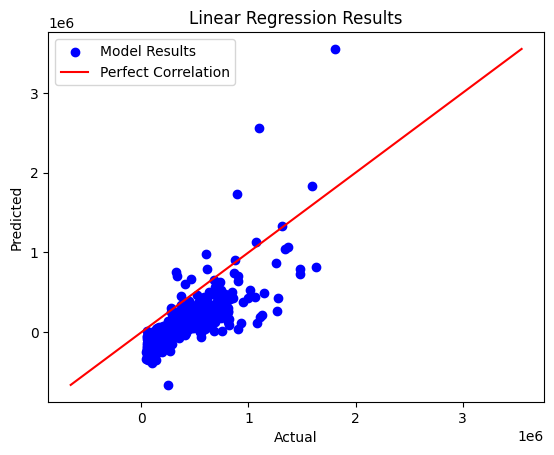

,Interval,Count,RMSE,Max_Difference
0,$0.0k to $100.0k,169,237675.6,479311.8
1,$100.0k to $200.0k,575,235920.0,486521.2
2,$200.0k to $300.0k,315,267026.1,907203.3
3,$300.0k to $400.0k,131,282222.8,428795.1
4,$400.0k to $500.0k,73,308207.7,442615.3
5,$500.0k to $600.0k,38,378777.3,616105.7
6,$600.0k to $700.0k,30,401625.8,658809.8
7,$700.0k to $800.0k,22,415902.7,729102.1
8,$800.0k to $900.0k,14,534117.2,839155.4
9,$900.0k to Maximum,25,768831.1,1742996.4


In [10]:
# Running linear regression with a constant on test set
model = sm.OLS(train_y.values, train_X)
results = model.fit()

# Using model to predict on our validation set and to compare predict values
predict_val = results.predict(val_X)

print('Validation results:')
display(analyze_results(val_y.values, predict_val, "Linear Regression"))

## Generalized Linear Models

/Users/kdevoe/Documents/CS/Masters/AAI500/FInal_Project/aai-500-final-group-4/env/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning:

The identity link alias is deprecated. Use Identity instead. The identity link alias will be removed after the 0.15.0 release.

/Users/kdevoe/Documents/CS/Masters/AAI500/FInal_Project/aai-500-final-group-4/env/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:307: DomainWarning:

The identity link function does not respect the domain of the Gamma family.



difference for training results (Gamma - Gaussian): $29375.112914092024
difference for validation results (Gamma - Gaussian): $54924.167594783474
[ 89700. 552800. 176300. ... 127300. 306400. 133100.]


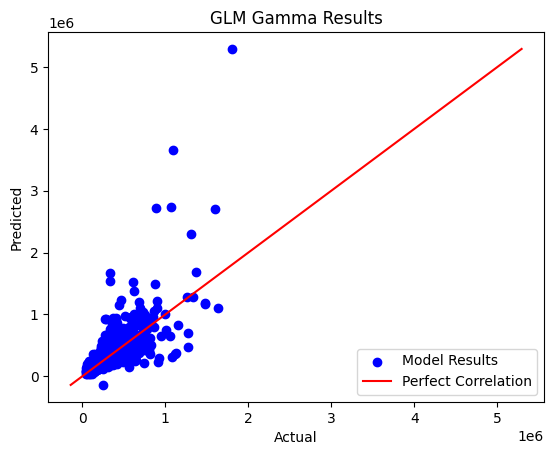

,Interval,Count,RMSE,Max_Difference
0,$0.0k to $100.0k,169,56604.4,160766.6
1,$100.0k to $200.0k,575,42969.3,227164.9
2,$200.0k to $300.0k,315,104304.6,652280.2
3,$300.0k to $400.0k,131,218805.2,1339834.2
4,$400.0k to $500.0k,73,211269.7,769037.0
5,$500.0k to $600.0k,38,214706.5,453904.4
6,$600.0k to $700.0k,30,324510.0,924256.9
7,$700.0k to $800.0k,22,199971.1,531886.1
8,$800.0k to $900.0k,14,579922.5,1829132.9
9,$900.0k to Maximum,25,1065577.9,3486223.1


In [11]:
# Instantiate a Gaussian family model with the default link function.
# Testing test set
glm_gaus = sm.GLM(train_y.values, train_X_min_max, family=sm.families.Gaussian())
res_gaus = glm_gaus.fit()
predict_glm_train = res_gaus.predict()
MSE = mean_squared_error(train_y, predict_glm_train)
sMSE_gaus_train = np.sqrt(MSE)


# Testing on Validation set
predict_glm_val = res_gaus.predict(val_X_min_max)
MSE = mean_squared_error(val_y, predict_glm_val)
sMSE_gaus_val = np.sqrt(MSE)


# Instantiate a gamma family model with the default link function.
# Test set
glm_gamma = sm.GLM(train_y.values, train_X_min_max , family=sm.families.Gamma(link=sm.genmod.families.links.identity()))
res_gamma = glm_gamma.fit()
predict_glm_gamma_train = res_gamma.predict()
MSE = mean_squared_error(train_y, predict_glm_gamma_train)
sMSE_gamma_train = np.sqrt(MSE)

# For validation set
predict_glm_gamma_val = res_gamma.predict(val_X_min_max)
MSE = mean_squared_error(val_y, predict_glm_gamma_val)
sMSE_gamma_val = np.sqrt(MSE)


# Calculating difference between gamma and gaussian SMSE results 
print(f"difference for training results (Gamma - Gaussian): ${sMSE_gamma_train-sMSE_gaus_train}")
print(f"difference for validation results (Gamma - Gaussian): ${sMSE_gamma_val-sMSE_gaus_val}")

display(analyze_results(val_y.values, predict_glm_gamma_val, "GLM Gamma"))

### XGBoost Evaluation

[ 89700. 552800. 176300. ... 127300. 306400. 133100.]


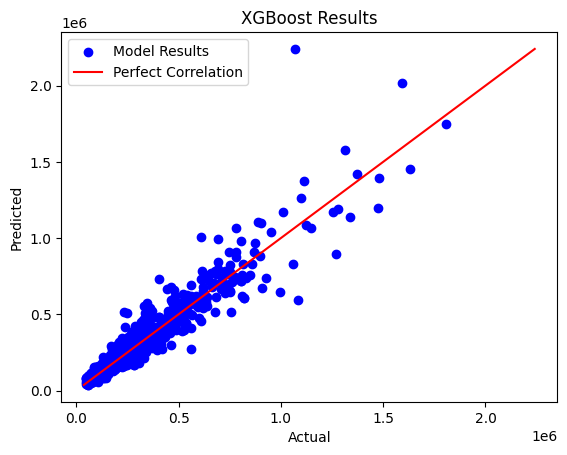

,Interval,Count,RMSE,Max_Difference
0,$0.0k to $100.0k,169,21320.2,67743.4
1,$100.0k to $200.0k,575,24741.4,118766.9
2,$200.0k to $300.0k,315,45991.3,281713.2
3,$300.0k to $400.0k,131,67584.2,228541.4
4,$400.0k to $500.0k,73,81477.5,324108.6
5,$500.0k to $600.0k,38,81804.4,290748.2
6,$600.0k to $700.0k,30,125821.9,399660.3
7,$700.0k to $800.0k,22,106853.9,289169.2
8,$800.0k to $900.0k,14,133464.2,218017.6
9,$900.0k to Maximum,25,323461.6,1170072.5


In [12]:
from xgboost import XGBRegressor

model = XGBRegressor()

# fit the model on the whole dataset
model.fit(train_X, train_y.values)

# make a single prediction
predict_xgboost_val = model.predict(val_X)

display(analyze_results(val_y.values, predict_xgboost_val, 'XGBoost'))

### Sequential Neural Network Evaluation

In [13]:
# Constants

BATCH_SIZE = 1
EPOCHS = 10
LR = 0.01

In [14]:
# Model definition
class Model(nn.Module):
    def __init__(self, input_size, output_size=1):
        super().__init__()

        self.hidden_dim = output_size + (input_size - output_size) // 2

        self.fc_1 = nn.Linear(input_size, self.hidden_dim)
        self.fc_2 = nn.Linear(self.hidden_dim, output_size)

    def forward(self, x):

        out = self.fc_1(x)
        out = F.relu(out)
        out = self.fc_2(out)

        return out

neural_model = Model(train_X.shape[1])
print(neural_model)

Model(
  (fc_1): Linear(in_features=50, out_features=25, bias=True)
  (fc_2): Linear(in_features=25, out_features=1, bias=True)
)


Run on GPU if available

In [15]:
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")

else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

neural_model.to(device)

GPU not available, CPU used


Model(
  (fc_1): Linear(in_features=50, out_features=25, bias=True)
  (fc_2): Linear(in_features=25, out_features=1, bias=True)
)

In [16]:
# Define the loss function and the optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(neural_model.parameters(), lr=LR)


In [17]:
# Training loop

def training_loop(model, train_X, train_y, val_X, val_y, num_epochs = 1, batch_size = 1):

    num_batches = len(train_X) // batch_size

    train_losses = []
    val_losses = []
    total_loss = 0

    for epoch in tqdm(range(num_epochs)):  # loop over the dataset for each epoch
        for batch in range(num_batches):
            # get the inputs; data is a list of [inputs, labels]
            start_index = batch * batch_size
            end_index = start_index + batch_size
            inputs = torch.from_numpy(train_X[start_index: end_index]).float().reshape(batch_size, -1)
            inputs.requires_grad = True
            labels = torch.from_numpy(np.asarray(train_y[start_index: end_index])).float().reshape(batch_size, -1)
            labels.requires_grad = True

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = torch.sqrt(criterion(outputs, labels))
            loss.backward()
            optimizer.step()

            total_loss += np.mean(loss.item())

        # Get the validation losses
        val_outputs = model(torch.from_numpy(val_X).float().reshape(len(val_X), -1))
        val_loss = torch.sqrt(criterion(val_outputs, torch.from_numpy(np.asarray(val_y)).float().reshape(len(val_y), -1)))

        average_loss = total_loss / num_batches
        train_losses.append(average_loss)
        val_losses.append(val_loss.detach().numpy())
        total_loss = 0  # Reset the total loss for the next epoch
        
    return train_losses, val_losses

100%|██████████| 10/10 [00:26<00:00,  2.70s/it]


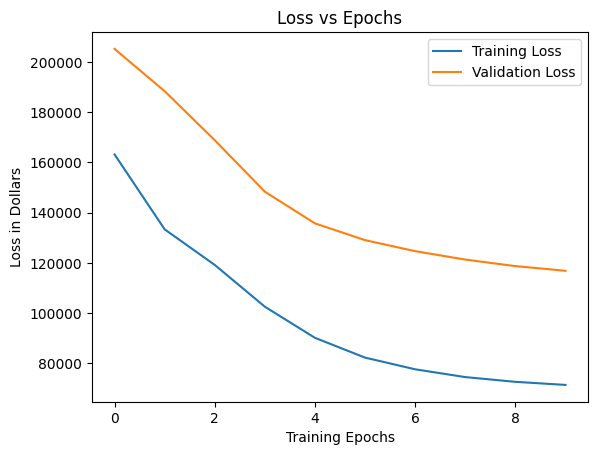

[ 89700. 552800. 176300. ... 127300. 306400. 133100.]


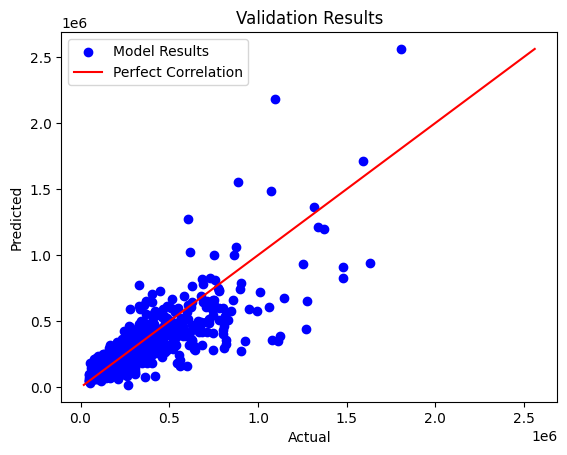

              Interval  Count     RMSE Max_Difference
0     $0.0k to $100.0k    169  40560.6    [143177.69]
1   $100.0k to $200.0k    575  44346.0     [157514.5]
2   $200.0k to $300.0k    315  68159.2    [309166.62]
3   $300.0k to $400.0k    131 106140.0     [444260.7]
4   $400.0k to $500.0k     73 122055.6    [330564.16]
5   $500.0k to $600.0k     38 187646.6    [432235.84]
6   $600.0k to $700.0k     30 243697.6    [663266.75]
7   $700.0k to $800.0k     22 202693.0     [469536.8]
8   $800.0k to $900.0k     14 373450.9    [659981.75]
9   $900.0k to Maximum     25 551357.1    [1082943.2]
10            All Data   1392 116866.0    [1082943.2]


In [18]:
train_losses, val_losses = training_loop(neural_model, train_X, train_y, val_X, val_y, num_epochs=EPOCHS, batch_size=BATCH_SIZE)

# Get predictions on the validation set
val_outputs = neural_model(torch.from_numpy(val_X).float().reshape(len(val_X), -1))
val_outputs = val_outputs.detach().numpy()

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Training Epochs')
plt.ylabel('Loss in Dollars')
plt.legend()

plt.show()

print(analyze_results(val_y.values, val_outputs, "Validation"))
